In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [4]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [5]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [6]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [7]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
symbol_indices_filename = f'ocean_symbol_idx_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'
res_filename = f'ocean_res_{today}.npy'

In [19]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [20]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

In [21]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [22]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649408.0
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186304.0
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725888.0
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0


In [23]:
def volume_features(df, period_14=14, period_20=20):
    df = df.copy()

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = df['Timestamp'].dt.date

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['True Range'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Previous Close']), abs(row['Low'] - row['Previous Close'])), axis=1)
    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    grouped = df.groupby(['Symbol', 'Date'])

    df['ADV'] = grouped['Volume'].transform('mean')
    df['IVR'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Turnover_Ratio'] = df['Volume'] / df['ADV'].replace(0, 1e-6)

    df['PVT'] = df['Close'].pct_change() * df['Volume']
    df['PVT'] = df.groupby('Symbol')['PVT'].cumsum()
    df['VMO'] = (df['Volume'] - df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).mean())) / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)

    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']
    df['Cum_Volume'] = grouped['Volume'].cumsum()
    df['Cum_Price_Volume'] = grouped['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e-6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()
    df['VWAP_STD'] = df.groupby('Symbol')['VWAP'].transform(lambda x: x.rolling(window=period_20).std())
    df['VWAP_UPPER'] = df['VWAP'] + (df['VWAP_STD'] * 2)
    df['VWAP_LOWER'] = df['VWAP'] - (df['VWAP_STD'] * 2)

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / (df['High'] - df['Low']).replace(0, 1e-6)
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio'].replace(0, 1e-6)
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['Price Change'] = grouped['Close'].diff()
    df['OBV'] = (np.sign(df['Price Change']) * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)
    df['A/D'] = grouped['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = grouped['Amihud_Illiquidity'].transform('mean')
    df['Amihud_Lambda'] = df['Amihud_Illiquidity'] / df['True Range'].replace(0, 1e-6)

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e-6)
    df['Liquidity_Shock'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).max()).replace(0, 1e-6)
    df['Liquidity_Shock_Volatility'] = df['True Range'] * df['Liquidity_Shock']

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] < 0, 0)

    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e-6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e-6)
    df['Depth_Proxy'] = (df['High'] - df['Low']) / df['Volume'].replace(0, 1e-6)

    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)

    df['NMP'] = df['Buy Volume'] - df['Sell Volume']
    df['MPR'] = df['NMP'].diff() / df['Volume'].replace(0, 1e-6)
    df['Cum_NMP'] = df.groupby('Symbol')['NMP'].cumsum()

    df['Volume_IMB'] = df.groupby('Symbol')['Buy Volume'].transform(lambda x: x.rolling(window=period_20).sum()) - df.groupby('Symbol')['Sell Volume'].transform(lambda x: x.rolling(window=period_20).sum())
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e-6)
    df['Flow_Imbalance_TW'] = df['Flow_R'].ewm(span=period_14, adjust=False).mean()

    df['Volume_Adjusted'] = df['Volume'].replace(0, 1e-6)
    df['Volume_Sum'] = df.groupby('Symbol')['Volume_Adjusted'].transform('sum')
    df['Volume_Entropy'] = -(df['Volume_Adjusted'] / df['Volume_Sum']) * np.log(df['Volume_Adjusted'] / df['Volume_Sum'])
    df['Volume_Entropy'] = df.groupby('Symbol')['Volume_Entropy'].cumsum()
    df['Volume_Skewness'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).skew()).replace(0, 1e-6)
    df['Volume_Surge'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Surge_Intensity'] = (df['Volume_Surge'] - 1) / df.groupby('Symbol')['Volume_Surge'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)
    df['Volume_Rank'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).apply(lambda y: pd.Series(y).rank(pct=True).iloc[-1]))

    df['CVD'] = df['Buy Volume'] - df['Sell Volume']
    df['CVD'] = df.groupby('Symbol')['CVD'].cumsum()
    df['CVD_Osc'] = df['CVD'].diff() / df['Volume'].replace(0, 1e-6)

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])).ewm(span=period_14, adjust=False).mean().replace(0, 1e-6)
    df['VROC'] = df['Volume'].pct_change(period_14)

    df['Market_Impact_Cost'] = (df['Close'] - df['VWAP']) * df['Volume']
    df['Price_Impact_Asymmetry'] = (df['Close'] - df['VWAP']) / df['True Range'].replace(0, 1e-6)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    drop_columns = [
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume',
        'Buy Volume', 'Sell Volume', 'Midpoint Move', 'Price Change', 'Positive Money Flow',
        'Negative Money Flow', 'Previous Close', 'Raw Money Flow', 'Volume_Adjusted', 'Volume_Sum', 'VWAP_STD',
    ]
    df.drop(columns=drop_columns, inplace=True)

    return df

In [24]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [11]:
volume_df = pd.read_csv(volume_df_filename)

In [12]:
volume_df.shape[0]

8034150

In [13]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,True Range,ADV,IVR,...,Volume_Surge,Surge_Intensity,Volume_Rank,CVD,CVD_Osc,RVOL,KVO,VROC,Market_Impact_Cost,Price_Impact_Asymmetry
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0,0.000009,213498380.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,-4.000000e+02,NaN,-0.0012,-0.333368
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649400.0,0.001688,213498380.0,NaN,...,NaN,NaN,NaN,719649400.0,1.0,NaN,1.757055e+08,NaN,359345.2200,0.295814
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186300.0,0.001314,213498380.0,NaN,...,NaN,NaN,NaN,-23536896.0,-1.0,NaN,1.147229e+08,NaN,75416.2500,0.077227
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725900.0,0.000498,213498380.0,NaN,...,NaN,NaN,NaN,-345262800.0,-1.0,NaN,1.157066e+08,NaN,-38096.6800,-0.237778
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0,0.000439,213498380.0,NaN,...,NaN,NaN,NaN,-554846400.0,-1.0,NaN,9.735090e+07,NaN,-56143.6520,-0.610210


In [14]:
symbols = volume_df['Symbol'].unique()
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [29]:
volume = ['ADV', 'IVR', 'RVOL', 'Volume_IMB', 'CVD', 'VROC', 'CVD_Osc', 'Volume_Entropy', 'NMP', 'Cum_NMP', 'PVT', 'VMO', 'Volume_Skewness', 'Volume_Surge', 'Surge_Intensity', 'Turnover_Ratio', 'Volume_Rank']
price_volume = ['VWAP', 'VWAP_MOM', 'VWAP_UPPER', 'VWAP_LOWER', 'MFI', 'Flow_R', 'Flow_Imbalance_TW', 'KVO', 'EOM']
liquidity = ['Amihud_Illiquidity', 'Amihud_Lambda', 'LII', 'Depth_Proxy', 'II', 'Liquidity_Ratio', 'Liquidity_Shock', 'Liquidity_Shock_Volatility']
accumulation_distribution = ['A/D', 'OBV', 'CMF']
market = ['Market_Impact_Cost', 'Price_Impact_Asymmetry']

features = volume + price_volume + liquidity + accumulation_distribution + market
n_features = len(features)

print("N Features: ", n_features)

N Features:  39


In [62]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

segment_length = 512
overlap = 128

print("NaN values before imputation:\n", volume_df.isna().sum())
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
volume_df[features] = imputer.fit_transform(volume_df[features])

symbol_sequences = [volume_df[volume_df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
print("Symbol seq: ", len(symbol_sequences))

def segment_sequence(sequence, segment_length, overlap, pad_left=False):
    segments = []
    step = segment_length - overlap

    for start in range(0, len(sequence), step):
        end = min(start + segment_length, len(sequence))
        segment = sequence[start:end]

        if len(segment) < segment_length:
            pad_width = segment_length - len(segment)

            if pad_left:
                segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
            else:
                segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

        segments.append(segment)

    return segments

def segment_all_sequences(sequences, segment_length, overlap):
    segmented_sequences = []
    segment_symbol_indices = []
    for symbol_idx, seq in enumerate(sequences):
        segments = segment_sequence(seq, segment_length, overlap)
        segmented_sequences.extend(segments)
        segment_symbol_indices.extend([symbol_idx] * len(segments))
    return segmented_sequences, segment_symbol_indices

segmented_sequences, segment_symbol_indices = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
segmented_sequences = np.array(segmented_sequences)

n_segments, segment_length, n_features = segmented_sequences.shape

scaler = StandardScaler()
segmented_sequences = segmented_sequences.reshape(-1, n_features)
normalized_segments = scaler.fit_transform(segmented_sequences)
normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

print("Shape of normalized features:", normalized_segments.shape)
print("Number of symbols:", n_symbols)

np.save(features_filename, normalized_segments)
np.save(symbol_indices_filename, segment_symbol_indices)


NaN values before imputation:
 Symbol                            0
Timestamp                         0
Open                              0
High                              0
Low                               0
Close                             0
Volume                            0
True Range                        0
ADV                               0
IVR                            7809
Turnover_Ratio                    0
PVT                               1
VMO                            5343
VWAP                              0
VWAP_MOM                        411
VWAP_STD                       7809
VWAP_UPPER                     7809
VWAP_LOWER                     7809
Box Ratio                         0
EOM                            5344
OBV                           84069
A/D                               0
CMF                            5363
Amihud_Illiquidity                0
Amihud_Lambda                     0
Liquidity_Ratio                   0
Liquidity_Shock                78

In [24]:
from notebooks.pipelines import ocean_train

epochs = 700
latent_dim = 32
lr = 1e-5

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_20_improved.pth
Start training with epochs 700
Epoch [1/700], Train Loss: 0.74231123
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Epoch [2/700], Train Loss: 0.74215304
Saved improved snapshot: snapshots/AutoEncoder_epoch_2_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_20_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Epoch [3/700], Train Loss: 0.74177852
Saved improved snapshot: snapshots/AutoEncoder_epoch_3_improved.pth
Epoch [4/700], Train Loss: 0.74150236
Saved improved snapshot: snapshots/AutoEncoder_epoch_4_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_2_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_3_improved.pth
Epoch [5/700], Train Loss: 0.74132956
Saved improved snapshot: snapshots/AutoEncoder_epoch_5_improved.pth
Saved periodic snapshot: snapshots/AutoEncoder_epoch_5_per

In [15]:
embeddings = np.load(emb_filename)
segment_symbol_indices = np.load(symbol_indices_filename)

print("Embedding shape:", embeddings.shape)
print("Symbol Idx shape:", segment_symbol_indices.shape)

symbol_embeddings_dict = {symbol: [] for symbol in symbols}

for i, symbol_idx in enumerate(segment_symbol_indices):
    symbol = symbols[symbol_idx]
    symbol_embeddings_dict[symbol].append(embeddings[i])

res_df = pd.DataFrame({
    'symbol': symbol_embeddings_dict.keys(),
    'embeddings': symbol_embeddings_dict.values()
})

print("DF shape:", res_df.shape)
print("\n", res_df.head())

Embedding shape: (20992, 32)
Symbol Idx shape: (20992,)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[0.3372114, 0.39398795, 0.12186401, 0.0226178...
1  1000000BABYDOGEUSDT  [[0.34317657, 0.3198296, 0.17213249, 0.0604145...
2       1000000MOGUSDT  [[0.23699513, 0.3377714, 0.05738382, 0.0413974...
3    1000000PEIPEIUSDT  [[0.25148574, 0.36698154, 0.11988755, -0.02907...
4         10000COQUSDT  [[0.3345824, 0.39062873, 0.07183676, 0.0957439...


In [13]:
all_embeddings = np.vstack(res_df['embeddings'].values)
all_embeddings.shape

(20992, 32)

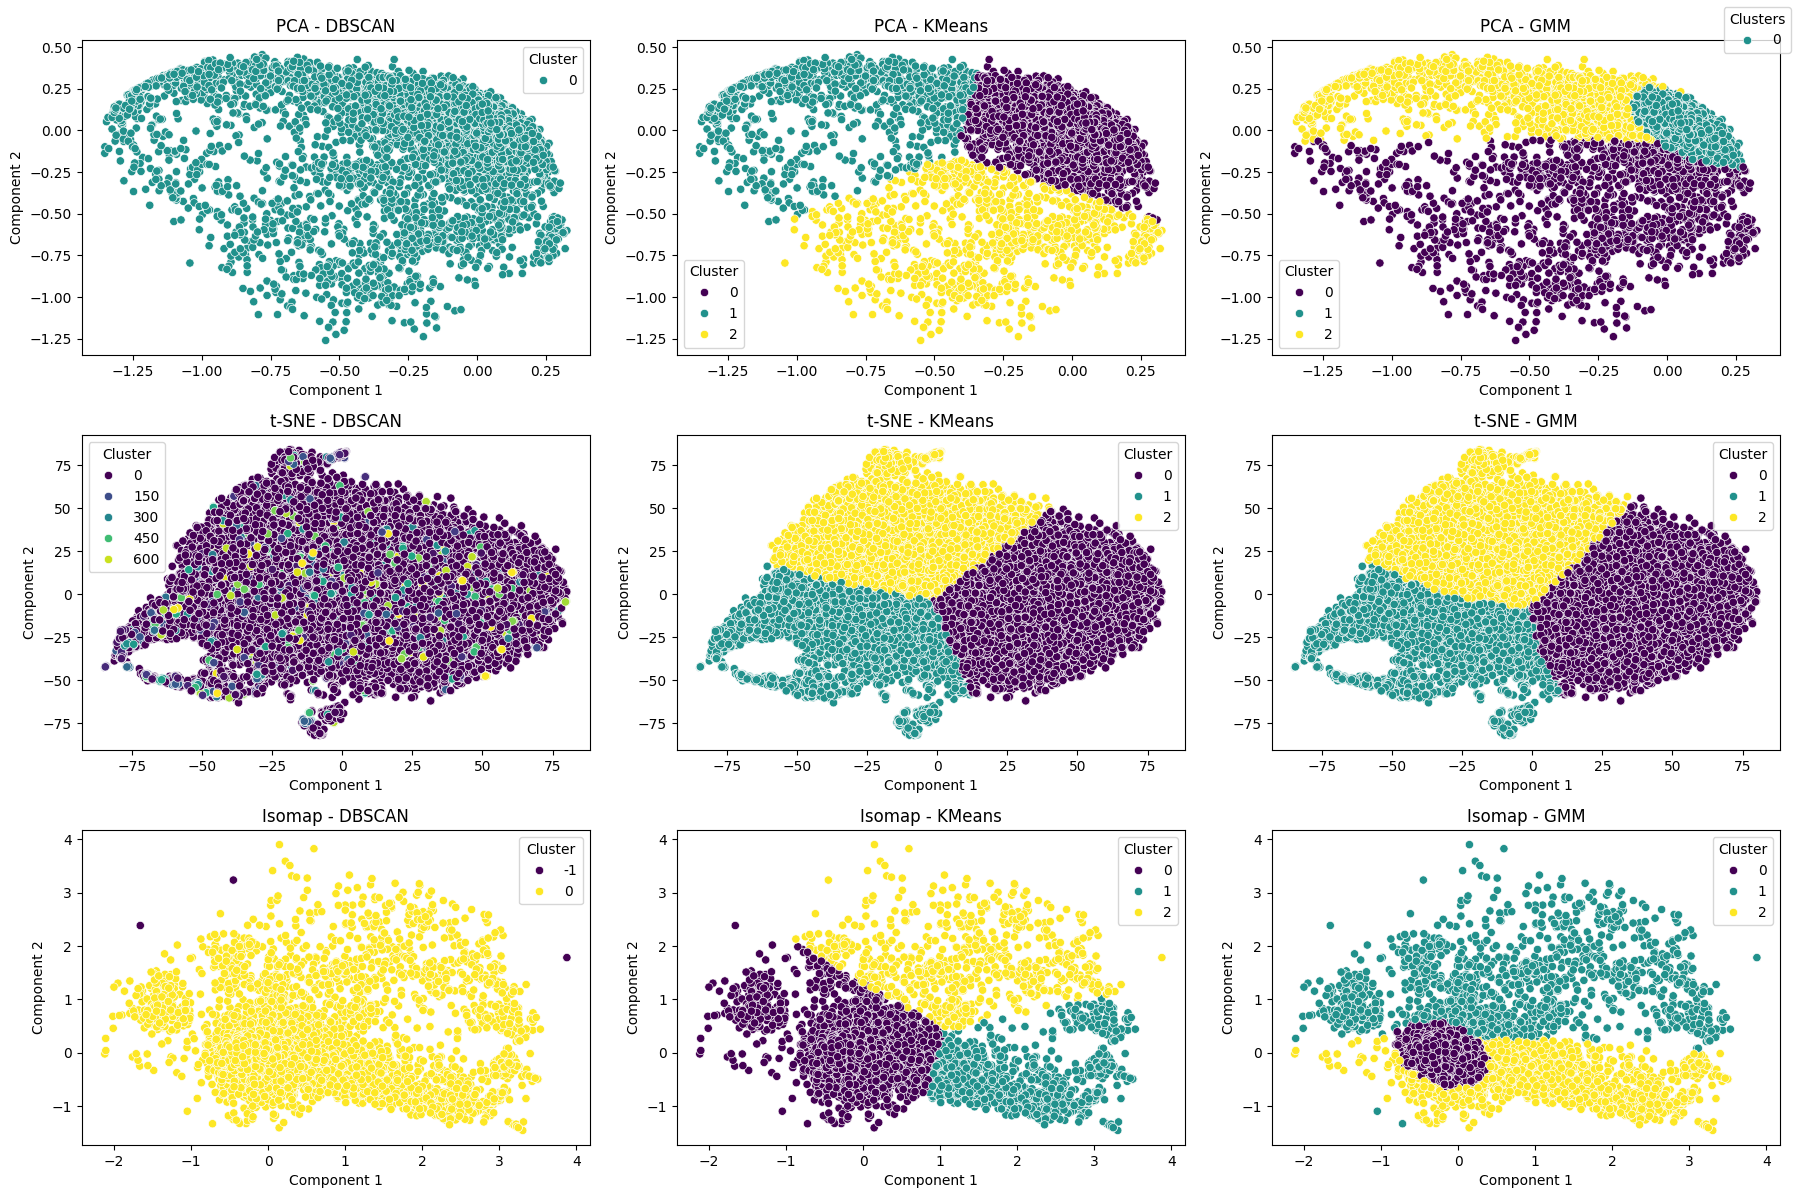

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.mixture import GaussianMixture

n_clusters = 3
n_components = 2

def visualize_clustering(all_embeddings, n_clusters=3, n_components=2, random_state=1337):
    clustering_methods = {
        "DBSCAN": DBSCAN(),
        "KMeans": KMeans(n_clusters=n_clusters),
        "GMM": GaussianMixture(n_components=n_clusters),
    }

    dimensionality_methods = {
        "PCA": PCA(n_components=n_components, random_state=random_state),
        "t-SNE": TSNE(n_components=n_components, random_state=random_state),
        "Isomap": Isomap(n_components=n_components),
        # "MDS": MDS(n_components=n_components),
        # "Factor Analysis": FactorAnalysis(n_components=n_components),
    }

    fig, axes = plt.subplots(len(dimensionality_methods), len(clustering_methods), figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (dim_name, dim_method) in enumerate(dimensionality_methods.items()):
        reduced_embeddings = dim_method.fit_transform(all_embeddings)

        for j, (cluster_name, cluster_method) in enumerate(clustering_methods.items()):
            cluster_labels = cluster_method.fit_predict(reduced_embeddings)

            df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
            df['Cluster'] = cluster_labels

            sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', ax=axes[i, j], legend='auto')
            axes[i, j].set_title(f'{dim_name} - {cluster_name}')
            axes[i, j].set_xlabel('Component 1')
            axes[i, j].set_ylabel('Component 2')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Clusters', loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_clustering(all_embeddings, n_clusters=n_clusters, n_components=n_components, random_state=seed)

In [16]:

def adjust_embedding_length(emb, target_length):
    emb = np.array(emb)

    if len(emb) < target_length:
        pad_width = target_length - len(emb)
        return np.pad(emb, (0, pad_width), 'constant')

    return emb[:target_length]

def flat_embeddings(df):
    df = df.copy()

    df['flat_embeddings'] = df['embeddings'].apply(lambda emb: [val for sublist in emb for val in sublist])

    embedding_lengths = df['flat_embeddings'].apply(len)
    max_length = embedding_lengths.max() if not embedding_lengths.empty else 0

    df['flat_embeddings'] = df['flat_embeddings'].apply(lambda emb: adjust_embedding_length(emb, max_length))

    return df

def reduce_embeddings(df, n_reduced=10):
    df = df.copy()

    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA(n_components=n_reduced)
    reduced_embeddings = pca.fit_transform(flat_embeddings)

    df['reduced_embeddings'] = list(reduced_embeddings)

    reduced_lengths = df['reduced_embeddings'].apply(len)
    reduced_uniq_lengths = reduced_lengths.value_counts()

    print("Reduced embedding lengths and counts:")
    print(reduced_uniq_lengths)

    return df

def optimal_n_components(df, threshold=0.90):
    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA()
    pca.fit(flat_embeddings)

    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    n_components = np.argmax(cumulative_variance >= threshold) + 1
    return n_components

flat_emb_df = flat_embeddings(res_df)
n_reduced = optimal_n_components(flat_emb_df)
print(f"n_components: {n_reduced}")

reduce_emb_df = reduce_embeddings(flat_emb_df, n_reduced=n_reduced)

simularity_values = reduce_emb_df[['symbol', 'reduced_embeddings']].values
print('\n', simularity_values[0])

np.save(f"out/{res_filename}", simularity_values)

n_components: 201
Reduced embedding lengths and counts:
reduced_embeddings
201    411
Name: count, dtype: int64

 ['10000000AIDOGEUSDT'
 array([ 0.02705164,  0.7391984 ,  1.0457256 ,  0.5247358 , -0.90863144,
         0.26180306, -1.4010515 ,  0.04063755,  0.4294429 , -0.04088396,
        -0.32322428,  0.36329156, -0.00743783, -0.12990236, -0.06178003,
         0.0825707 ,  0.0668215 , -0.36735108, -0.00915881,  0.11489042,
        -0.0743823 ,  0.23816986,  0.05299967, -0.03093986,  0.39785174,
        -0.46565324,  0.42358428,  0.36838427, -0.16175908,  0.2985533 ,
         0.6054812 ,  0.1804298 ,  0.09980256,  0.363269  , -0.1709273 ,
         0.15443577,  0.02349597,  0.48577976, -0.17029779, -0.26925722,
         0.5182515 ,  0.22024643,  0.10580699,  0.10079943,  0.51024014,
         0.29286495,  0.53655195, -0.38717327,  0.15362884, -0.42274046,
         0.2290015 , -0.21147023,  0.64542204, -0.5277057 ,  0.04606177,
        -0.19324565, -0.12370691,  0.15659392,  0.01878253, -

In [17]:
from ocean import SIM

max_level = 8
max_neighbors = 40
ef_construction = 500
ef_search = 50

gsim = SIM(
    max_level=max_level,
    max_neighbors=max_neighbors,
    ef_construction=ef_construction,
    ef_search=ef_search
)

embs = np.load(f"out/{res_filename}", allow_pickle=True)

for symbol, emb in embs:
    gsim.insert(emb, symbol)

In [19]:
from core.models.cap import CapType

symbol = 'SOLUSDT'
val = reduce_emb_df[reduce_emb_df['symbol'] == symbol]['reduced_embeddings'].values
query = val[0]

print(f"Symbol: {symbol}")

neighbors = gsim.search(query, 8)
n_neighbors = len(neighbors)

print(f"Found {n_neighbors} nearest neighbors for the query.")

for i, neighbor in enumerate(neighbors):
    dist, node = neighbor
    print(f"{i} neighbor Symbol: {node.meta['symbol']}")

simular_symbols = gsim.find_similar_symbols(symbol, 4)
n_symbols = len(simular_symbols)

print(f"Found {n_symbols} simular symbols")

for symbol in simular_symbols:
    print(f"Symbol: {symbol}")

cap = CapType.A
cap_symbols = gsim.find_similar_by_cap(cap, top_k=18)
n_symbols = len(cap_symbols)

print(f"Found {n_symbols} symbols by: {cap.name}")

for symbol in cap_symbols:
    print(f"Symbol: {symbol}")

Symbol: SOLUSDT
Found 8 nearest neighbors for the query.
0 neighbor Symbol: STPTUSDT
1 neighbor Symbol: SWEATUSDT
2 neighbor Symbol: VRAUSDT
3 neighbor Symbol: RPLUSDT
4 neighbor Symbol: GMXUSDT
5 neighbor Symbol: FUNUSDT
6 neighbor Symbol: UNIUSDT
7 neighbor Symbol: FILUSDT
Found 5 simular symbols
Symbol: STPTUSDT
Symbol: SWEATUSDT
Symbol: VRAUSDT
Symbol: RPLUSDT
Symbol: GMXUSDT
Found 18 symbols by: A
Symbol: WAXPUSDT
Symbol: UNFIUSDT
Symbol: RSRUSDT
Symbol: SUNUSDT
Symbol: WLDUSDT
Symbol: SSVUSDT
Symbol: TRBUSDT
Symbol: THETAUSDT
Symbol: RPLUSDT
Symbol: TOMIUSDT
Symbol: XLMUSDT
Symbol: SEIUSDT
Symbol: USTCUSDT
Symbol: STGUSDT
Symbol: YFIUSDT
Symbol: ZENUSDT
Symbol: TIAUSDT
Symbol: SNTUSDT
